# Neural Networks for Data Science Applications
## Homework 1: Customized activation functions

**Name**: *Francesco Lazzari*

**Matricola**: *1917922*

> ✍ Upload the completed notebook **before 13/11/2024 at 23:59** on the Google Classroom page.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**) and 1 optional exercise. The optional one is ungraded but I may take it into consideration for the final mark during the oral.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. Marks between 4 and 5 can be fully recovered during the oral examination.
3. If you want to improve the mark, you are also free to complete the full EoT homework to recover a full mark.
3. The grade can be kept for the entire academic year (up to October 2025).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and JAX*: the homework must be done _fully in JAX_ (except where specified) while vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

### Introduction: Trainable activation functions

Remember that a trainable variant of the Swish function can be written as:

$$ \phi(s) = (as + b)\sigma(cs + d) $$

where $s$ is the scalar input of the AF, $\left\{a, b, c, d\right\}$ are four scalar parameters, and $\sigma$ is the sigmoid function. Note how this can be (roughly) interpreted as a one-hidden layer MLP with one input, one hidden unit, and one output. Thus, we can easily generalize this as:

$$ \phi(s) = \sum_{i=1}^n (a_is+b_i)\sigma(c_is+d_i) \tag{1} $$

where $n$ is an hyper-parameter, and the function has now $4n$ parameters $\left\{a_i, b_i, c_i, d_i\right\}_{i=1}^n$. By varying $n$ we can make the activation function as complicated as we want: we say this is a **non-parametric** AF [1]. The homework will guide you to implement an MLP exploiting (1) in JAX.

In [1]:
import jax
import jax.numpy as jnp

from typing import Tuple
from jaxtyping import Array, Float

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

from flax import linen as nn
from flax.core import frozen_dict
from clu import metrics
from flax.training import train_state  
import optax 
from flax import struct  

### Exercise 1 (1 point)

We begin by implementing (1) (no MLPs for now) in JAX. Following what we saw in the first lab session, implement equation (1) in pure JAX (no external libraries) using a pair of (init, call) functions, respectively for initializing the parameters and for computing the outputs of the AF.

For the purpose of this exercise we consider a single AF with mini-batching over the input, hence the signature of the functions should be:

```
def init_fcn(key, n):
   # key is the PNRG state
   # n is the hyper-parameter in (1)
   # Returns: the parameters (a,b,c,d) in whatever format you prefer.
```


```
def call_fcn(params, x: Float[Array, "b"])
           -> Float[Array, "b"]:
   # x is a vector (mini-batch) of b inputs to the function
   # params is the output of init_fcn
   # Returns the corresponding outputs ϕ(x1), ϕ(x2), ..., ϕ(xb).
```






✅ **Completion requirement**: Show me the two functions work as expected. For example, you can plot some randomly-initialized functions for different choices of $n$.

In [2]:
# TODO: implement Exercise 1.

def init_fcn(key: jax.random.PRNGKey, n: int) -> Tuple[ Float[Array,'n'], Float[Array,'n'], Float[Array,'n'], Float[Array,'n'] ]:
    keys = jax.random.split(key, 4)
    a = jax.random.normal(keys[0], (n,))
    b = jax.random.normal(keys[1], (n,))
    c = jax.random.normal(keys[2], (n,))
    d = jax.random.normal(keys[3], (n,))
    return a, b, c, d

def call_fcn(params: Tuple[ Float[Array,'n'], Float[Array,'n'], Float[Array,'n'], Float[Array,'n'] ], x: Float[Array,'b']) -> Float[Array, 'b']:
    a, b, c, d = params
    return jnp.sum((a * x[:, None] + b) * jax.nn.sigmoid(c * x[:, None] + d), axis=-1)

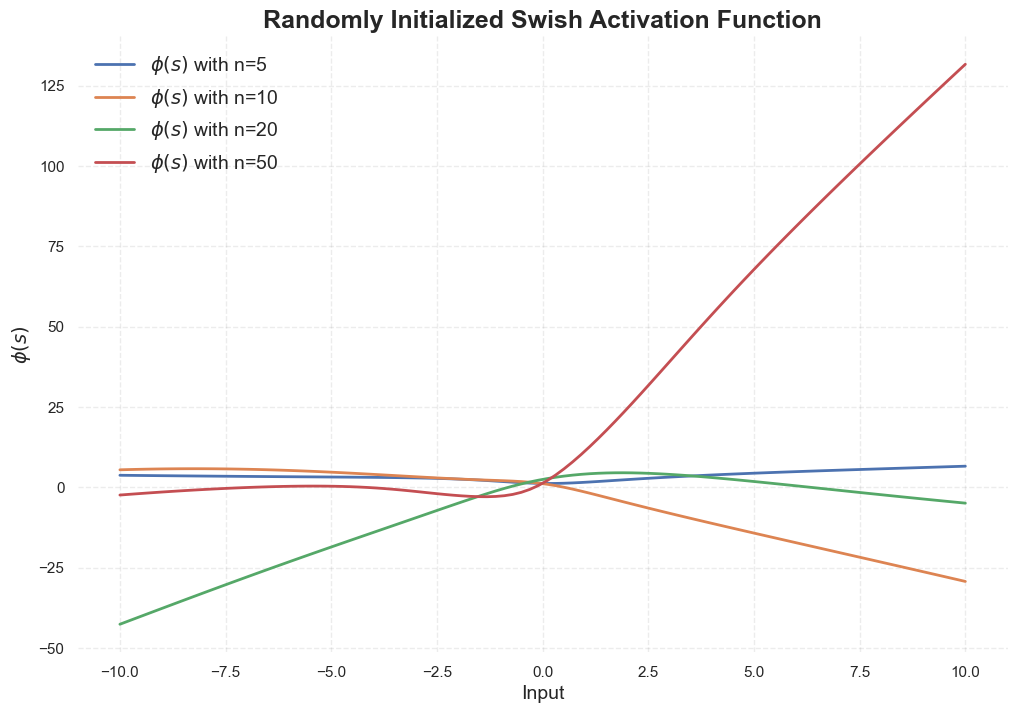

In [3]:
# Test of the activation function   
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Generation of the inputs
x = jnp.linspace(-10, 10, 100)

# Initialization of the parameters
key = jax.random.PRNGKey(0)
# key, subkey = jax.random.split(key)
n_val = [5, 10, 20, 50]

for n in n_val:
    params = init_fcn(key, n) # here if we use the 'subkey' instead the 'key' we will get the same 'params' for the AF of the model in point 4 (before training) (for n=5 [remove the other values of 'n_val' to see better the single line])
    y = call_fcn(params, x)
    plt.plot(x, y, lw=2, label=f'$\phi(s)$ with n={n}') 
#=================================================================================================================
# NOTE:
# please read the comment at the end of the first plot in point 4 (AF before and after training) for an explanation of why the AF-parameters in the model are initialized with the subkey instead of the key (even if the key was passed to the 'model.init' function)
#=================================================================================================================
plt.xlabel('Input', fontsize=14)
plt.ylabel('$\phi(s)$', fontsize=14)
plt.title('Randomly Initialized Swish Activation Function', fontsize=18, fontweight='bold')
plt.legend(prop={'size': 14}, edgecolor= 'white', facecolor='white', framealpha=0)
plt.grid(True, linestyle='--', color='gray', alpha=0.15)
sns.despine(left=True, bottom=True)
plt.show()

### Exercise 2 (1 point)

One issue of non-parametric AF is that they tend to work poorly when randomly-initialized. However, it is relatively easy to fix the parameters of (1) so that the initialized functions approximate any scalar function we desire (in fact, (1) for $n \rightarrow \infty$ is a universal approximator for 1D functions).

For this exercise, write a gradient descent procedure (again, pure JAX) that given $n$ finds the optimal coefficients $\left\{a_i, b_i, c_i, d_i\right\}$ such that:

$$ \phi(s) \approx \text{ReLU}(s) $$

Note that all functions from Exercise 1 and 2 should be scalar-valued apart from mini-batching.

✅ **Completion requirement**: Show me gradient descent converges correctly. For example, you can plot the quality of the approximation when increasing $n$.

In [4]:
# TODO: complete Exercise 2.

# Loss function
@jax.jit # here we are using the jax.jit decorator to compile the update function in order to speed up the computation
@jax.value_and_grad # here we are using the jax.value_and_grad decorator to compute the gradients of the loss function
def loss(params: Tuple[Float[Array, 'n'], Float[Array, 'n'], Float[Array, 'n'], Float[Array, 'n']], x: Float[Array, 'b']) -> float:
    y_pred = call_fcn(params, x)
    y_true = jax.nn.relu(x)  # ReLU is used as target function since we want to prove that our Swish function can approximate it
    return jnp.mean((y_pred - y_true) ** 2)

# Update step of the GD algorithm
@jax.jit # here we are using the jax.jit decorator to compile the update function in order to speed up the computation
def update(params, grads, learning_rate=0.001):
    '''
    in this version of the update step we use the function jax.tree_util.tree_map to apply the update rule to all the parameters
    '''
    return jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

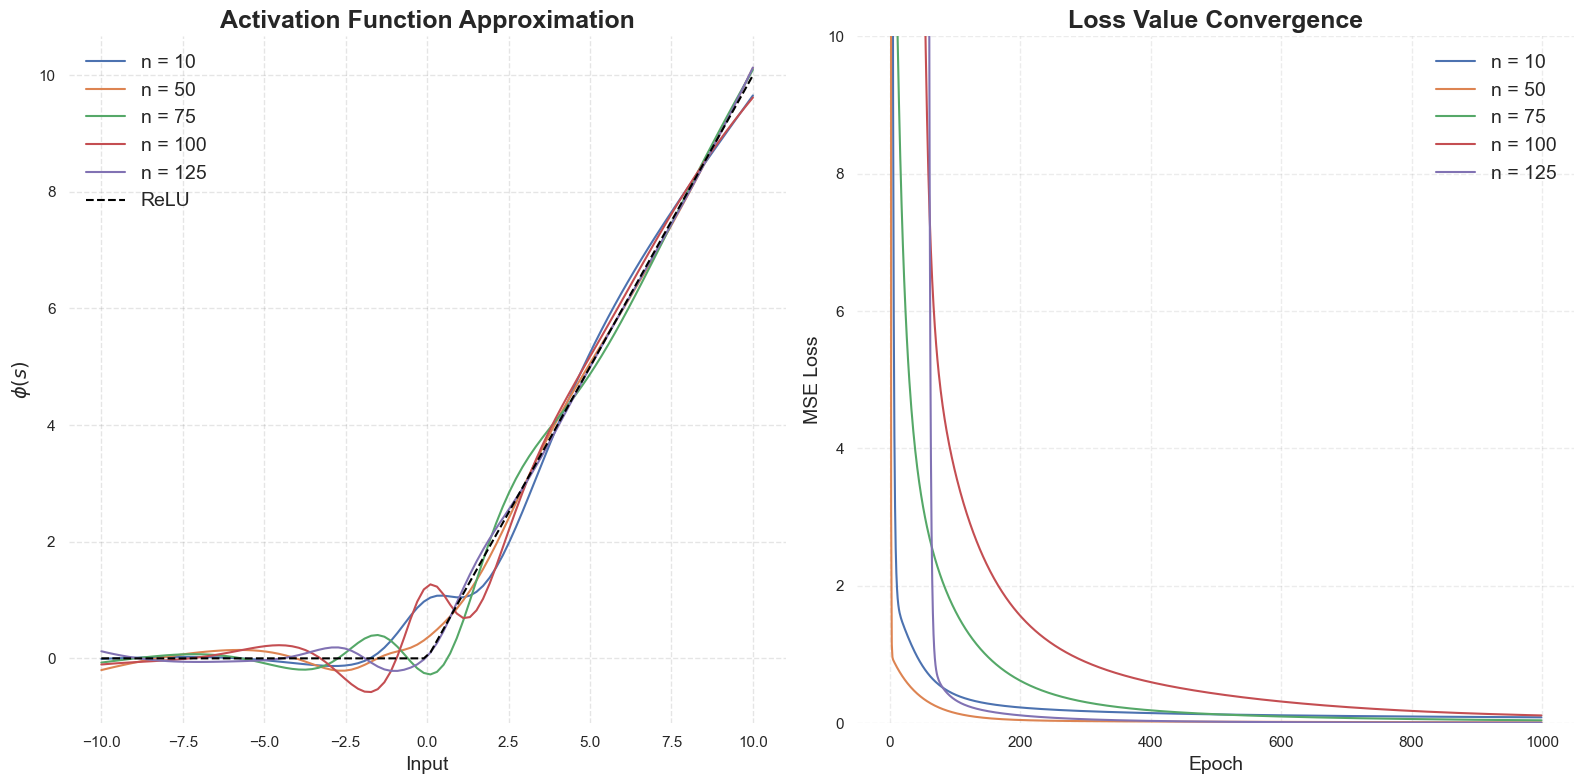

In [5]:
# Gradient descent procedure
key = jax.random.PRNGKey(0)
x = jnp.linspace(-10, 10, 100) 
n_values = [10, 50, 75, 100, 125]  #NOTE: for n>126 (with learning rate = 0.001) we start to have instability issues 

# Plot global settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for n in n_values:
    params = init_fcn(key, n)
    loss_history = []

    for epoch in range(1000):
        loss_value, grads = loss(params, x)
        params = update(params, grads)
        loss_history.append(loss_value)

    y = call_fcn(params, x)
    # add the results to the plots
    axes[0].plot(x, y, label=f'n = {n}')
    axes[1].plot(loss_history, label=f'n = {n}')

# Plot the true ReLU function
y_true = jax.nn.relu(x)
axes[0].plot(x, y_true, label='ReLU', linestyle='dashed', color='black')

# Plot settings for the activation function approximations
axes[0].set_xlabel('Input', fontsize=14)
axes[0].set_ylabel('$\phi(s)$', fontsize=14)
axes[0].set_title('Activation Function Approximation', fontsize=18, fontweight='bold')
axes[0].grid(True, linestyle='--', color='gray', alpha=0.2)
axes[0].legend(prop={'size': 14}, edgecolor= 'white', facecolor='white', framealpha=0)

# Plot settings for the loss convergence
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('MSE Loss', fontsize=14)
axes[1].set_title('Loss Value Convergence', fontsize=18, fontweight='bold')
axes[1].grid(True, linestyle='--', color='gray', alpha=0.15)
axes[1].legend(prop={'size': 14}, edgecolor= 'white', facecolor='white', framealpha=0)
axes[1].set_ylim([0, 10])  # here i adjusted the y-axis limits to zoom on the loss values convergence

# Additional settings for better visualization 
sns.despine(left=True, bottom=True)
plt.tight_layout()  
plt.show()

### Exercise 3 (1 point)

Clearly, a single activation function is not enough. For example, consider the following Sequential model in Keras:

```
model = Sequential([
  Dense(5),
  ReLU(),
  Dense(1)  
])
```
We would like to replace the intermediate ReLU layer with an equivalent layer implementing (1), where each unit (neuron) in the layer is assigned a different AF. Luckily, we can use `jax.vmap` over the result of Exercise 1 to solve this.

For this exercise, apply `vmap` over `call_fcn` to obtain the following variants:

1.   A single AF (shared parameters) for all the units of the layer.
2.   Different AFs (different parameters) for each unit in the layer.
3. (**Optional, more difficult**) A KAN-style AF [2] where a different AF is applied to each edge of a fully-connected layer.

The signature of all vmapped functions should be:

```
def vmapped_call_fcn(params, x: Float[Array, "b h"])
           -> Float[Array, "b h"]:
   ...
```
where $x$ is a generic output of a fully-connected layer, so that $h$ is the number of hidden units in the layer (e.g., $h=5$ for the first `Dense` layer above). For the new initialization functions, you are free to either rewrite them or find some way to vectorize the original one.

✅ **Completion requirement**: Show me the vectorization works as expected (e.g., generate and visualize multiple functions simultaneously).

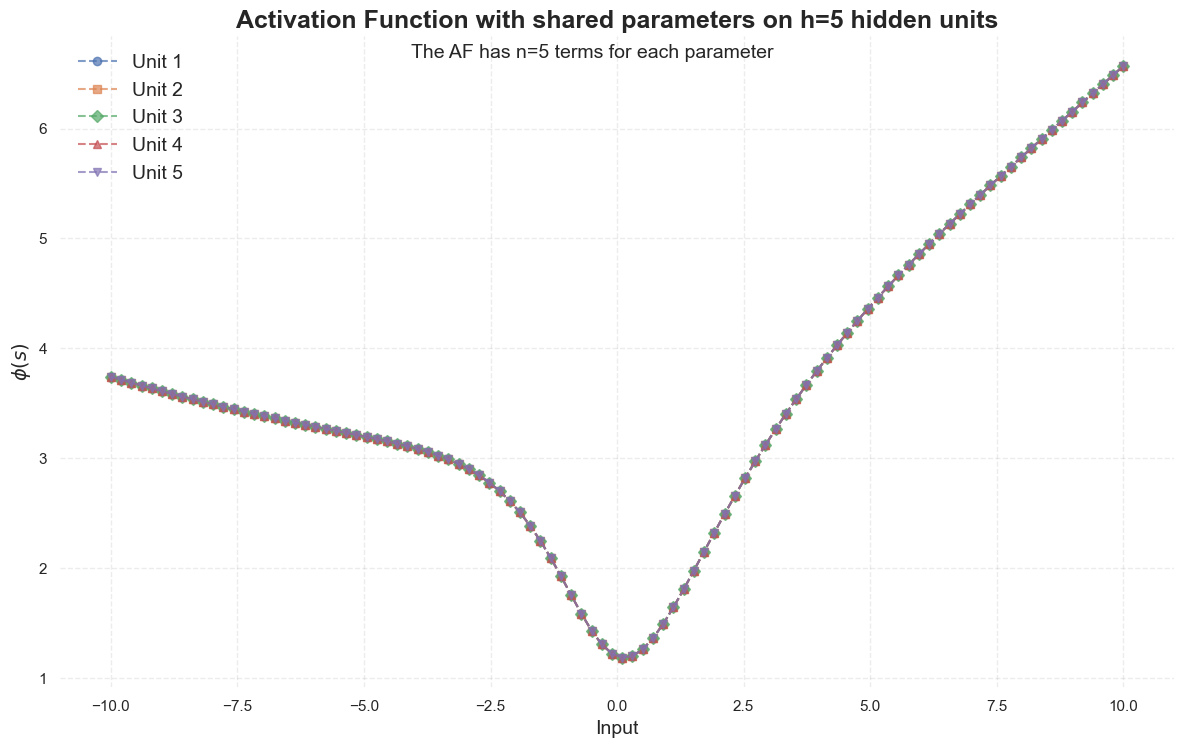

In [6]:
# TODO: complete Exercise 3.

#####################################
### Single AF (Shared Parameters) ###
#####################################

def call_fcn_shared(params, x: Float[Array, "b h"]) -> Float[Array, "b h"]:
    return jax.vmap(lambda xi: call_fcn(params, xi), in_axes=1, out_axes=1)(x)

# Initialization of the parameters
key = jax.random.PRNGKey(0)
n = 5  # hyperparameter of the AF 
h = 5  # number of units

# Generation of the inputs
xi = jnp.linspace(-10, 10, 100)    # here i am generating the input values
x = jnp.tile(xi[:, None], (1, h))  # here i am replicating the same input for all the hidden units

# Computation of the outputs
params = init_fcn(key, n)
outputs = call_fcn_shared(params, x)  

# Plot global settings
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot the results
markers = ['o', 's', 'D', '^', 'v']  # Different markers for each unit
for i in range(h):
    plt.plot(xi, outputs[:, i], label=f'Unit {i+1}', linestyle='--', marker=markers[i], alpha=0.7)
plt.title(f'Activation Function with shared parameters on h={h} hidden units', fontsize=18, fontweight='bold')
plt.suptitle(f'The AF has n={n} terms for each parameter', y=0.89, fontsize=14)
plt.xlabel('Input', fontsize=14)
plt.ylabel('$\phi(s)$', fontsize=14)
plt.grid(True, linestyle='--', color='gray', alpha=0.15)
plt.legend(prop={'size': 14}, edgecolor= 'white', facecolor='white', framealpha=0)

# Additional settings for better visualization 
sns.despine(left=True, bottom=True)
plt.tight_layout()  
plt.show()

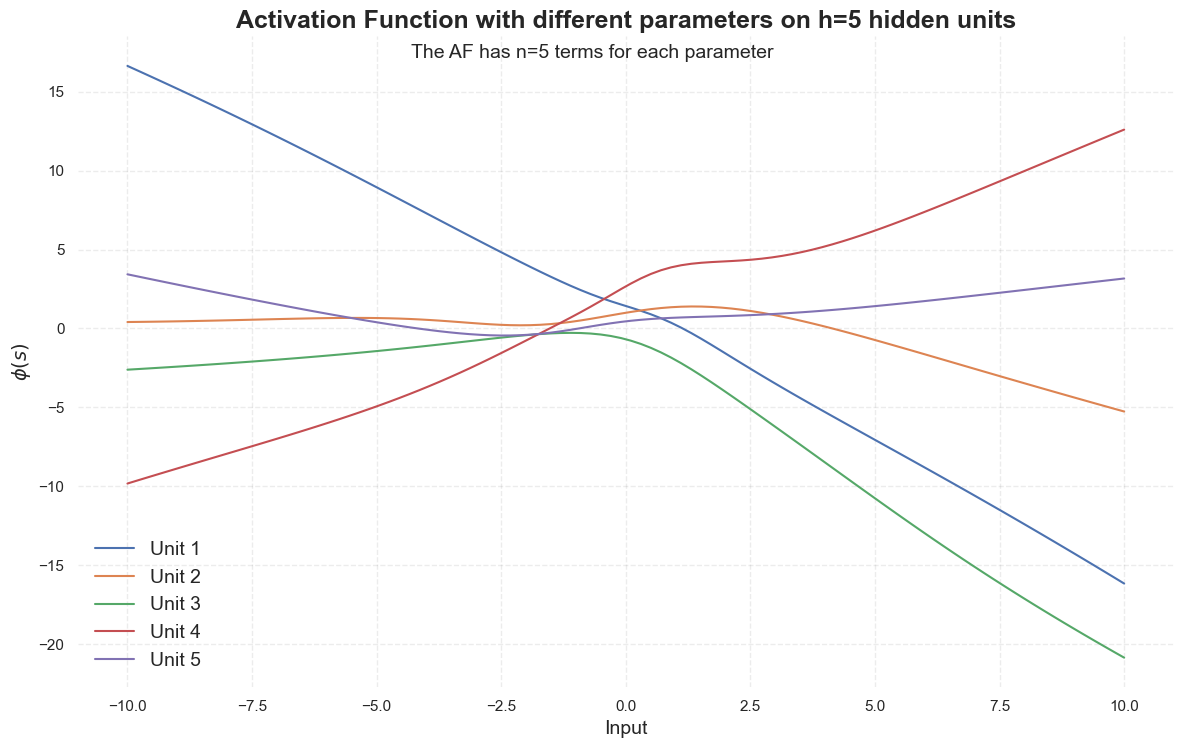

In [7]:
############################################
### Different AFs (Different Parameters) ###
############################################

def init_fcn_different(key: jax.random.PRNGKey, n: int, h: int) -> Tuple[ Float[Array,'h n'], Float[Array,'h n'], Float[Array,'h n'], Float[Array,'h n']]:
    keys = jax.random.split(key, 4)
    a = jax.random.normal(keys[0], (h, n))
    b = jax.random.normal(keys[1], (h, n))
    c = jax.random.normal(keys[2], (h, n))
    d = jax.random.normal(keys[3], (h, n))
    return a, b, c, d

def call_fcn_different(params, x: Float[Array, "b h"]) -> Float[Array, "b h"]:
    return jax.vmap(call_fcn, in_axes=(0, 1), out_axes=1)(params, x)

# Initialization of the parameters
key = jax.random.PRNGKey(0)
n = 5  # hyperparameter of the AF 
h = 5  # number of units

# Generation of the inputs
xi = jnp.linspace(-10, 10, 100)      # here i am generating the input values
x = jnp.tile(xi[:, None], (1, h))  # here i am replicating the same input for all the units

# Computation of the outputs
params = init_fcn_different(key, n, h)
outputs = call_fcn_different(params, x)  

# Plot global settings
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot the results
for i in range(h):
    plt.plot(xi, outputs[:, i], label=f'Unit {i+1}')
plt.title(f'Activation Function with different parameters on h={h} hidden units', fontsize=18, fontweight='bold')
plt.suptitle(f'The AF has n={n} terms for each parameter', y=0.89, fontsize=14)
plt.xlabel('Input', fontsize=14)
plt.ylabel('$\phi(s)$', fontsize=14)
plt.grid(True, linestyle='--', color='gray', alpha=0.15)
plt.legend(prop={'size': 14}, edgecolor= 'white', facecolor='white', framealpha=0)

# Additional settings for better visualization 
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Exercise 4 (2 point)

It is now time to train an MLP with our new activation functions. To begin with, select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

The objective of the exercise is to train an MLP with one hidden layer having as activation functions (1). In order to do this you have multiple choices:

1. You can do this completely in JAX by defining a new pair of (init, call) functions describing the complete model and performing gradient descent with these.
2. If you want to use Keras (note: `.fit` is *not allowed*) as in the second lab session, you need to port the trainable function in Keras. My suggestion is to subclass the `Layer` object by wrapping the functions you have already created (https://keras.io/guides/making_new_layers_and_models_via_subclassing/). The resulting layer will be backend-specific, which is not an issue. If you want something slightly harder, you can rewrite everything with Keras ops to make it backend-agnostic.
3. You can also use some high-level JAX library (e.g., Equinox, Haiku, ...). In this case, please document the code precisely.

✍ **DESCRIPTION OF THE DATASET**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

---

The California Housing Dataset contains information collected from the 1990 census about demographics and housing in various areas of California. The dataset consists of 20,640 samples, where each sample is a census block, that were collected by the **Statistic Department** of the **Carnegie Mellon University**. This data were published on [**StatLib**](https://lib.stat.cmu.edu/), which is a system for distributing statistical software, datasets, and information and then added to the library [`sklearn.datasets`](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset). 

Each row has the following 8 continuous features with no missing values:
- `MedInc`: median income in the area.
- `HouseAge`: median age of the houses in the area.
- `AveRooms`: average number of rooms per dwelling.
- `AveBedrms`: average number of bedrooms per dwelling.
- `Population`: population of the area.
- `AveOccup`: average number of occupants per household.
- `Latitude`: latitude of the area.
- `Longitude`: longitude of the area.

At the end there is a 9-th column `MedHouseVal` which is the target variable that we want to predict which is the median house value in different areas expressed in thousands of dollars ($100,000).

In [8]:
# Load the California housing dataset
ds = fetch_california_housing()       
# Show the first 5 rows of the data
pd.concat([pd.DataFrame(ds.data, columns=ds.feature_names), pd.DataFrame(ds.target, columns=['MedHouseVal'])], axis=1).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [9]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(ds.data, ds.target, test_size=0.2, random_state=42)

# Convert the data into jnp.float32 
x_train, x_test, y_train, y_test = map(jnp.float32, [x_train, x_test, y_train, y_test])

# Create a single dataset for the training and testing sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle, batch, and prefetch the training set
train_batches = train_ds.shuffle(20000, seed=456).batch(32).prefetch(tf.data.AUTOTUNE)
# with shuffle(20000) we are shuffling the entire dataset so that the batches are created with random observations from the entire training set
# the number of batch to prefetch is set to AUTOTUNE which allows TensorFlow to automatically set the number of batches to prefetch based on the available memory

# Show the length of each set
print(f'- Train set: {train_ds.cardinality().numpy()} observations\n- Test set: {test_ds.cardinality().numpy()} observations')
print(f'- Number of batches in the training set per epoch: {train_batches.cardinality().numpy()}') 
# also 'len' would have worked but 'cardinality' seems to be the correct way to get the number of batches (i think it is more efficient and more reliable)

# NOTE: this solution allows to easily create shuffled batches for the training set and prefetch them
#       but the con is that now the data are not in a jax array format, so we need to convert them when we extract each batch

- Train set: 16512 observations
- Test set: 4128 observations
- Number of batches in the training set per epoch: 516


✅ **Completion requirement**: Show me the model trains as expected (e.g., loss, accuracy). It would be nice to visualize the functions before and after training.

In [10]:
# TODO: complete Exercise 4.

# /!\ NOTE: 
# the following code is based on various examples found online of how to use the Flax / Optax / CLU libraries 
# all the code was still written by me and explained in detail in the comments so if there are some mistakes in the comments its due to my misunderstanding 
# just for example i used as source the following link: https://flax.readthedocs.io/en/v0.8.3/quick_start.html 
# for the optax optimizer i referred to the official documentation: https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam
# for the clu metrics please see the note in the next chunk

class TrainSwish_shared(nn.Module):
    sum_terms: int

    def setup(self):
        # in flax in order to define a trainable parameter we need to use the '.param' method
        # the first argument is the name of the parameter, the second argument is a function that initializes the parameter
        self.af_params = self.param('af_params', lambda key: init_fcn(key, self.sum_terms))

    def __call__(self, x):
        return call_fcn_shared(self.af_params, x)


class FCNN(nn.Module):
    hidden_units: int  # Number of hidden units
    af_n: int          # Number of terms in the activation function

    # Definition of the structure of each layer of the network
    # this method is automatically executed with the <.init(key, x_sample)> method to initialize the parameters 
    def setup(self):
        self.hidden_layer = nn.Dense(self.hidden_units) 
        self.output_layer = nn.Dense(1)  # since this is a regression problem, the output layer has only one unit
        self.activation = TrainSwish_shared(sum_terms=self.af_n)

    # Definition of the Forward pass of the network
    # in order to apply the model we will need to call the method '.apply' 
    # if the parameter 'method' is not specified during the '.apply' call, then the '__call__' method is automatically called
    # so, for example, if we define an additional forwad pass we can call it by specifying <method='forward'> inside <.apply(...)> 
    def __call__(self, x):
        x = self.hidden_layer(x)      # Apply of the hidden layer
        x = self.activation(x)        # Apply of the trainable Swish Activation Function function
        x = self.output_layer(x)      # Apply of the output layer
        return x

# ===================================
# Model Creation and Initialization 
# ===================================

# Creation of the model
model = FCNN(hidden_units=5, af_n=5)
# Initialization of the model
key = jax.random.PRNGKey(0)
# we initialize the model by calling the 'init' method of the model passing the key and some dummy input data
# the dummy input data is used and needed to infer the shapes of the parameters so it must have the same shape as the training data
# NOTE: 
# we could also use the real training data (i.e. 'train') but this wouldn't change the resuls since we need only the shapes of the data and not the actual values --> in fact the number of rows is not important
model_parameters = model.init(key, jnp.ones((1, 8)))   # we have 8 features in the input data

# ===============================================
# Here we save the initial parameters of the AF
# ===============================================

# all the parameters of the model are stored in a nested dictionary (i.e. a dictionary of dictionaries)
# the parameters of the model are stored in the 'params' key of the dictionary (first level)
# inside the 'params' dictionary we have the parameters of each layer of the model under the name of the layer (second level)
# i.e. {'params': {'hidden_layer': ..., 'output_layer': ..., 'activation': ...}}
# inside the 'activation' sub-dictionary we have the parameters of the AF under the name 'af_params'
# i.e. {'params': {'activation': {'af_params': ...}, ... }}

swish_params = frozen_dict.freeze(model_parameters['params']['activation'])
# we use the frozen_dict.freeze method to convert the dictionary to an immutable dictionary in order to avoid accidental modifications  --> the method need a dictionary as input so we cant directly save only the parameters of the AF
# if we want to access the parameters of the AF we can use the 'af_params' key --> swish_params['af_params']

# ==========================
# Model Parameters Summary
# ==========================

# Model summary with a sample input with the same shape as the training data
print(model.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 8))))

# hidden layer has 8 input features and 5 hidden units    --> 8*5 parameters (kernel / weights) + 5 bias = 45 parameters 
# activation function has 5 terms                         --> 5*4 parameters = 20 parameters
# output layer has 5 hidden units and 1 output unit       --> 5*1 parameters + 1 bias = 6 parameters



                                  FCNN Summary                                  
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module         ┃ inputs       ┃ outputs      ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ FCNN           │ float32[1,8] │ float32[1,1] │                │
├──────────────┼────────────────┼──────────────┼──────────────┼────────────────┤
│ hidden_layer │ Dense          │ float32[1,8] │ float32[1,5] │ bias:          │
│              │                │              │              │ float32[5]     │
│              │                │              │              │ kernel:        │
│              │                │              │              │ float32[8,5]   │
│              │                │              │              │                │
│              │                │              │              │ 45 (180 B)     │
├──────────────┼───────────

In [11]:
# ==========================================================================
# Definition of the Metrics dataclass with a custom Adjusted R2Score metric
# ==========================================================================


# NOTE: 
# the implementation of the custom R2Score metric was done following the example in the CLU GitHub repository 
# https://github.com/google/CommonLoopUtils/blob/main/clu/metrics.py  (see line 106-121 + 166-169)

# Definition of the custom Adjusted R2Score metric class 
@struct.dataclass  
class R2Score(metrics.Metric):
    ssr: jnp.float32  # SSR (sum of squared residuals)
    sst: jnp.float32  # SST (total sum of squares)
    n: jnp.int32      # Number of samples
    k: jnp.int32      # Number of predictors

    @classmethod
    def empty(cls):
        # Here we define the initial values of the metric
        # this method is needed for the initialization of the metric when we create the TrainState dataclass
        return cls(
            ssr=jnp.array(0.0, dtype=jnp.float32), 
            sst=jnp.array(0.0, dtype=jnp.float32),
            n=jnp.array(0, dtype=jnp.int32),
            k=jnp.array(0, dtype=jnp.int32)
        )

    @classmethod
    def from_model_output(cls, y, y_pred, n, k,  **kwargs):
        # Here we compute the SSR and SST from the model outputs
        # the **kwargs argument is used to pass additional arguments that we don't need for this metric but are needed for other metrics (e.g. the MSE loss in this case)
        ssr = jnp.sum((y - y_pred) ** 2)
        y_mean = jnp.mean(y)
        sst = jnp.sum((y - y_mean) ** 2)
        return cls(
            ssr=ssr,
            sst=sst,
            n=jnp.array(n, dtype=jnp.int32),
            k=jnp.array(k, dtype=jnp.int32)
        )

    def merge(self, other):
        # Here we define the merge operation of the metric in the case we want to calculate the metric over multiple batches and then merge the results
        # i'm not sure if this is the correct way of merging the r2score over multiple batches
        # Since we are computing the R2 score at the end of each epoch on the entire dataset, we don't need to merge the results of the metric so this method is not used ad was added just for completeness / consistency
        return R2Score(
            ssr=self.ssr + other.ssr, 
            sst=self.sst + other.sst, 
            n=self.n + other.n,
            k=self.k                  # we don't need to merge the 'k' value since it is the same for all the batches
        )

    def compute(self):
        r2 = 1 - ((self.n-1)/(self.n-self.k-1))*(self.ssr / (self.sst + 1e-8)) # we added a small value to the denominator to avoid division by zero
        return r2

# the metrics module of the clu library provides a framework for for functional metric computation
# the metrics.Collection class is used to store multiple metrics into a single object
@struct.dataclass   # required decorator for JAX transformations
class Metrics(metrics.Collection):
    r2: R2Score
    loss: metrics.Average.from_output('loss')  # here we use the 'from_output' method to create a metric that computes the average of the 'loss' output

# =======================================
# Definition of the TrainState dataclass
# =======================================

# the TrainState dataclass is used to store the state of the training loop
class TrainState(train_state.TrainState):
  metrics: Metrics  # we store the metrics of the model in the TrainState dataclass

# Initialization of the TrainState of the model
state = TrainState.create(
    apply_fn=jax.jit(model.apply),      # the jax.jit function is used to compile the Forward pass of the model
                                        # since we used jit its important that all the operations are done with immutable datatypes like jax.numpy.array and flax.core.frozen_dict
    params=model_parameters,            # we pass directly the parameters of the model
                                        # NOTE: its better if we pass the entire 'model_parameters' dictionary with also the 'params'
                                        # key cause its needed by the flax library for the gradient and loss computation 
                                        # (otherwise we should recreate the original dictionary inside the 'mse_loss' function)
    tx=optax.adam(0.001),               # we the Stochastic Gradient Descent optimizer with a gradient scaling adaptation --
    metrics=Metrics.empty()             # we initialize the metrics of the model with empty values
)

# ===================================
# Update Step with MSE Loss Function
# ===================================

# Definition of the loss function
@jax.jit
def mse_loss(params):
    y_pred = state.apply_fn(params, x)  # here we apply the Forward pass of the model stored inside the TrainState dataclass (already compiled with jax.jit)
    # NOTE: if the params dictionary doesn't contain the 'params' key (but only the sub-dictionary) we have to recreate the original dictionary with {'params', params}
    return jnp.mean((y_pred - y) ** 2)  # MSE computation

@jax.jit
def update(state, x, y):
    # Computation of the gradients and the loss
    loss, grad = jax.value_and_grad(mse_loss)(state.params)  
    # NOTE: we are passing the only the 'params' dictionary to avoid error in the computation of the gradients since we want only the gradient of the parameters of the model and not of the entire TrainState dataclass

    # Update the params of the model saved in the TrainState class 
    state = state.apply_gradients(grads=grad)
    return state

# ===================
# Metric Computation 
# ===================

@jax.jit
def metrics_computation(state, x, y):

    # Computation of the Loss and the Accuracy
    y_pred = state.apply_fn(state.params, x)
    loss = jnp.mean((y_pred - y) ** 2)  # since we need the loss and also the prediction we compute the loss here instead of using the 'mse_loss' function
    
    # Update the metrics of the model
    metrics = state.metrics.single_from_model_output(
        y_pred=y_pred,
        y=y,
        n=x.shape[0],  # number of observations
        k=x.shape[1],  # number of features
        loss=loss
    )
    # metrics = state.metrics.merge(metrics)  # here we could merge the results of the if they were computed over multiple batches but this is not the case
    state = state.replace(metrics=metrics)

    return state

In [12]:
metrics_history = {'Train MSE Loss': [],
                   'Train Adj R^2': [],
                   'Test MSE Loss': [],
                   'Test Adj R^2': []}

# Training loop
for epoch in range(1, 101):
    # Parameters update after each batch
    for x, y in train_batches:
        x = jnp.array(x, dtype=jnp.float32)
        y = jnp.array(y, dtype=jnp.float32)
        state = update(state, x, y)       

    # Metrics computation after each epoch
    state = metrics_computation(state, x_train, y_train)  # we compute the metrics on the entire training set with the parameters of the model updated after one epoch
    metrics_history['Train MSE Loss'].append(state.metrics.loss.compute())
    metrics_history['Train Adj R^2'].append(state.metrics.r2.compute())

    state = metrics_computation(state, x_test, y_test)    # we compute the metrics on the entire test set with the parameters of the model updated after one epoch
    metrics_history['Test MSE Loss'].append(state.metrics.loss.compute())    
    metrics_history['Test Adj R^2'].append(state.metrics.r2.compute())

    # Print the metrics
    if epoch % 10 == 0 or epoch == 1 :
        print(f'Epoch {epoch}\n- Train MSE Loss: {metrics_history["Train MSE Loss"][-1]:.4f}\n- Test MSE Loss: {metrics_history["Test MSE Loss"][-1]:.4f}\n')

# Save the final parameters of the model Trainable Swish Activation Function
final_params = state.params['params']['activation']['af_params']

Epoch 1
- Train MSE Loss: 741.0007
- Test MSE Loss: 717.4838

Epoch 10
- Train MSE Loss: 12.2083
- Test MSE Loss: 13.7057

Epoch 20
- Train MSE Loss: 4.5098
- Test MSE Loss: 5.5215

Epoch 30
- Train MSE Loss: 3.2329
- Test MSE Loss: 1.7876

Epoch 40
- Train MSE Loss: 3.6490
- Test MSE Loss: 1.6930

Epoch 50
- Train MSE Loss: 3.4396
- Test MSE Loss: 1.7181

Epoch 60
- Train MSE Loss: 3.3283
- Test MSE Loss: 1.7349

Epoch 70
- Train MSE Loss: 3.1619
- Test MSE Loss: 1.7196

Epoch 80
- Train MSE Loss: 2.8758
- Test MSE Loss: 1.7045

Epoch 90
- Train MSE Loss: 2.6645
- Test MSE Loss: 1.6574

Epoch 100
- Train MSE Loss: 2.4607
- Test MSE Loss: 1.6478



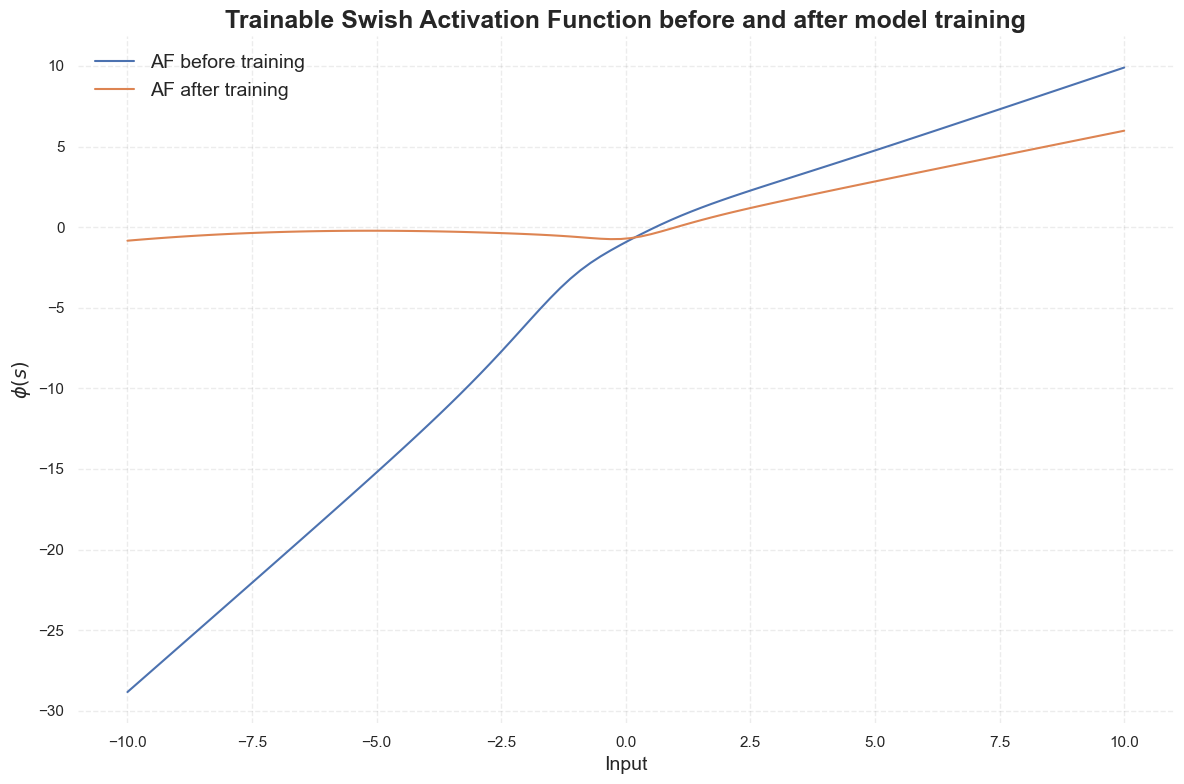

In [13]:
# Activation Function parameters befor and after training

xi = jnp.linspace(-10, 10, 100)      # here i am generating the input values

out1 = call_fcn(swish_params['af_params'], xi)  
out2 = call_fcn(final_params, xi)  

# Plot global settings
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot the results
sns.lineplot(x=xi, y=out1, label=f'AF before training')
sns.lineplot(x=xi, y=out2, label=f'AF after training')
plt.title(f'Trainable Swish Activation Function before and after model training', fontsize=18, fontweight='bold')
plt.xlabel('Input', fontsize=14)
plt.ylabel('$\phi(s)$', fontsize=14)
plt.grid(True, linestyle='--', color='gray', alpha=0.15)
plt.legend(prop={'size': 14}, edgecolor= 'white', facecolor='white', framealpha=0)

# Additional settings for better visualization 
sns.despine(left=True, bottom=True)
plt.tight_layout()  
plt.show()

# ==========================================================================================
# NOTE: 
# even if we used the same 'key' as for the plot in point 1 the two set of initial parameters are different
# this is due to the internal split that the Flax module automatically apply on the key passed to the '.init' method of the model
# this split ensures that all the parameters inside the 'setup' method are initialized with different keys so in fact we are non passing our key to the 'init_fcn' function but a subkey of it
# to prove this we can run again the plot in point 1 using the 'subkey' variable instead of the 'key' variable and we will see that this time the blue line here will be the same as the one in that plot

# Again as in Point 2 we can see that the Trainable Swish AF converges to the ReLU AF so i would say that the model is working correctly (the quality of the approximation is not constant)

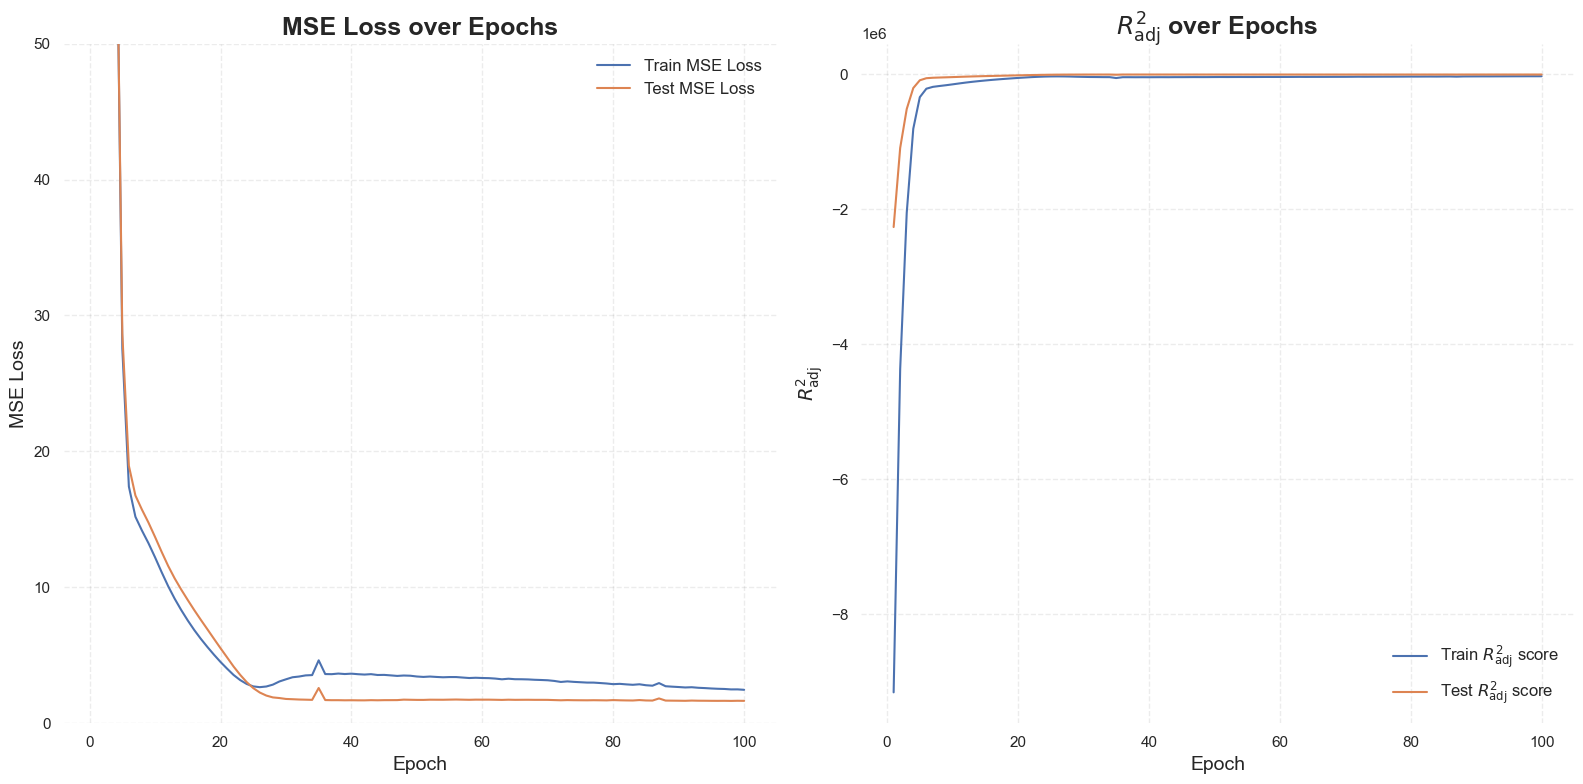

In [14]:
epoch_range = range(1, 101)

# Plot global settings
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# Convert the single metrics in a compatible format for the plots
train_mse_loss = jnp.array(metrics_history['Train MSE Loss'])
test_mse_loss = jnp.array(metrics_history['Test MSE Loss'])
train_r2 = jnp.array(metrics_history['Train Adj R^2'])
test_r2 = jnp.array(metrics_history['Test Adj R^2'])

# ================
# MSE Loss - Plot
# ================
sns.lineplot(ax=axes[0], x=epoch_range, y=train_mse_loss, label='Train MSE Loss')
sns.lineplot(ax=axes[0], x=epoch_range, y=test_mse_loss, label='Test MSE Loss')
axes[0].set_title('MSE Loss over Epochs', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('MSE Loss', fontsize=14)
axes[0].legend(prop={'size': 12}, edgecolor='white', facecolor='white', framealpha=0)
axes[0].grid(True, linestyle='--', color='gray', alpha=0.15)
axes[0].set_ylim([0, 50])

# =====================
# Adj R2 Score - Plot
# =====================
sns.lineplot(ax=axes[1], x=epoch_range, y=train_r2, label=r'Train $R^{2}_{\text{adj}}$ score')
sns.lineplot(ax=axes[1], x=epoch_range, y=test_r2, label=r'Test $R^{2}_{\text{adj}}$ score')
axes[1].set_title(r'$R^2_{\text{adj}}$ over Epochs', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel(r'$R^2_{\text{adj}}$', fontsize=14)
axes[1].legend(prop={'size': 12}, edgecolor='white', facecolor='white', framealpha=0)
axes[1].grid(True, linestyle='--', color='gray', alpha=0.15)

# Additional settings for better visualization
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# ==========================================================================================
# NOTE:
# since the value of the Adj R^2 is negative this means that the model is not able to capture the variance of the data 
# this is due to the fact that the model is too simple and probably needs more layers to capture the complexity of the data
#
#  I already tried to increare the number of hidden units and the number of terms in the AF but the results didn't change much
#
# From the convergence of the loss values we can see that the model is not able to predict correctly the target values 

### Exercise 5 (optional, ungraded)

It could happen that the model does not work as expected because the parameters of the AF collapse to some "weird" behaviour. We can partially solve this by imposing a **regularization** term on the loss that penalizes deviations from the initialization.

For example, suppose that CE is the cross-entropy loss, and we initialize our AFs as the ReLU. If we have a single AF for simplicity, we can penalize deviations from the initialization as:

$$ \arg\min \sum_z \text{CE}(y_z, \hat{y}_z) + \lambda \sum_{i} (\phi(s_i) - \text{ReLU}(s_i))^2 \tag{2} $$

where $z$ loops over the training dataset, $\lambda\ge 0$ is a hyper-parameter that balances the strength of the regularization, and $s_i$ are a set of points sampled on the x-axis (the more points we sample, the stronger the regularization). This can be extended trivially to multiple AFs by summing over the different functions.

For this exercise, modify the training from Exercise 4 by including a term as in (2) (not necessarily the same, it is enough that it has a similar effect).


✅ **Completion requirement**: Show me regularization works as expected (e.g., compare the trained AFs to those from Exercise 4).

In [15]:
# TODO: complete exercise 5.



### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 13/11/2024 23:59** on the Google Classrom page.

### References

[1] Apicella, A., Donnarumma, F., Isgrò, F. and Prevete, R., 2021. A survey on modern trainable activation functions. Neural Networks, 138, pp. 14-32.

[2] Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., Hou, T.Y. and Tegmark, M., 2024. KAN: Kolmogorov-Arnold networks. arXiv preprint arXiv:2404.19756.